# Example: Single Cell Gene Expression Trajectories

[Packer et al.](https://www.science.org/doi/10.1126/science.aax1971) demonstrated
how single-cell RNA sequencing uncovers trajectories relating to the cell 
development in the *C. elegans*. These trajectories can be seen as a branching
structure that we can detect with FLASC. In this notebook, we show how HDBSCAN\*
and FLASC can be applied on this data set.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import lensed_umap as lu
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from umap import UMAP
from umap.umap_ import reset_local_connectivity
from flasc import FLASC
from flasc.prediction import branch_centrality_vectors, update_labels_with_branch_centrality
from hdbscan import HDBSCAN
from sklearn.preprocessing import normalize
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components

from _plotting import *

%matplotlib inline
palette = configure_matplotlib()

## Data

The dataset and pre-processing is described in the 
[documentation of Monocle 3](https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/).
In essence, different measuring batches are aligned, so that measuring noise is
reduced. Then, the first 50 PCA coordinates are taken to reduce noise and focus
on the main patterns. We prepared a file with these 50 PCA coordinates:

In [3]:
df = pd.read_csv('./data/elegans_preprocessed.csv', index_col=0)
df.shape

(6188, 50)

Because HDBSCAN\* does not support the cosine distance without reverting to an
inefficient quadratic implementation, we normalize the rows so that the
Euclidean distance captures the angle between rows. Essentially computing the
Angular distance rather than the Cosine distance.

In [4]:
# Normalize so euclidian captures angles
X = normalize(df, norm='l2')

## Clusters

First, we look at the clusters in this data. We use FLASC here only because it provides different plotting functionality on the condensed cluster hierarchy. Effectively, what we show are the HDBSCAN\* clusters.

In [5]:
# Run HDBSCAN* on the data
c = FLASC(
    min_samples=5,
    min_cluster_size=50,
    min_branch_size=500,
    branch_detection_method="core",
    branch_selection_method="eom",
).fit(X)

We plot the data in 2D using UMAP and use the function below to label the detected clusters.

In [6]:
# Embed down to 2D
p = UMAP(n_neighbors=20, n_components=2, transform_mode="graph").fit(X)
p = lu.embed_graph(p, repulsion_strengths=[0.03, 0.3, 0.03], epoch_sequence=[300, 300, 100])
X2 = p.embedding_

c:\Users\jelme\micromamba\envs\work\lib\site-packages\pynndescent\pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "c:\Users\jelme\micromamba\envs\work\lib\site-packages\numba\core\types\functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
c:\Users\jelme\micromamba\envs\work\lib\site-packages\pynndescent\pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/depr

In [7]:
def label_groups(X, labels, x_offset=0.2, y_offset=0.2):
    center = np.nanmean(X, axis=0)
    centroids = [np.nanmean(X[labels == i], axis=0) for i in range(labels.max())]
    quadrant = [(ctr[0] <= center[0]) + 2 * (ctr[1] <= center[1]) for ctr in centroids]
    coords = [
        [
            ctr[0] + x_offset * (1 if q % 2 == 0 else -1),
            ctr[1] + y_offset * (1 if q < 2 else -1),
        ]
        for q, ctr in zip(quadrant, centroids)
    ]
    for l, ctr in enumerate(coords):
        plt.text(ctr[0], ctr[1], f"{l}")

These clusters appear to correspond to structure in the 2D embedding quite nicely. Only the cluster hierarchy itself does not indicate which clusters are near each other.

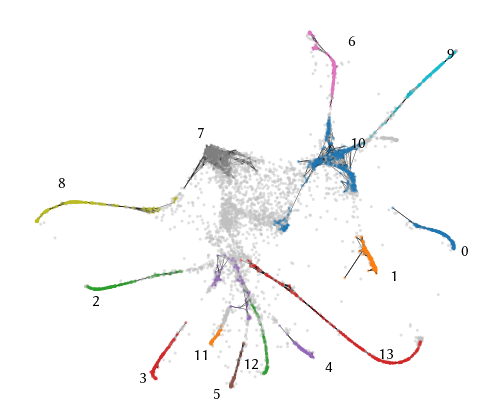

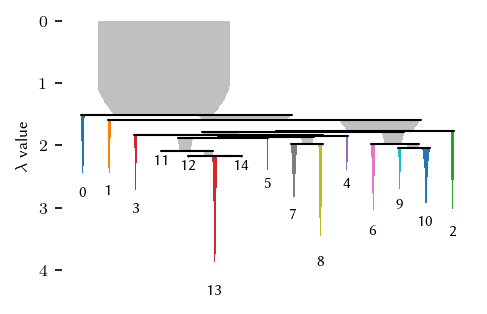

In [8]:
# Plot result
fig = sized_fig(1)
graph = c.cluster_approximation_graph_
cmap = plt.colormaps["tab10"].colors
graph.plot(
    positions=X2, 
    node_color=c.cluster_labels_ % 10, 
    node_cmap='tab10', 
    node_vmin=0,
    node_vmax=9,
    node_size=2, 
    node_alpha=0.5,
    edge_width=0.2
)
label_groups(X2, c.cluster_labels_)
frame_off()

fig = sized_fig(1/2)
c.condensed_tree_.plot(leaf_separation=0.2, label_clusters=True)
plt.subplots_adjust(0, 0, 1, 1)
# plt.savefig('./images/elegans_umap.png', dpi=600)
plt.show()

### Clusters in the embedding

Looking at clusters in an embedding can also be interesting, as it the embedding process attempts to denoise the data's structure. In this case, it provides additional sub-clusters, but the hierarchy does not imporve.

In [9]:
# Embed down to 3D
p.n_components = 5
del p.embedding_
p = lu.embed_graph(p, repulsion_strengths=[0.03, 0.3, 0.03], epoch_sequence=[300, 300, 100])

# Run HDBSCAN* on the data
c = FLASC(
    min_samples=20,
    min_cluster_size=65,
    min_branch_size=500,
    branch_detection_method="core",
    branch_selection_method="eom",
).fit(p.embedding_)

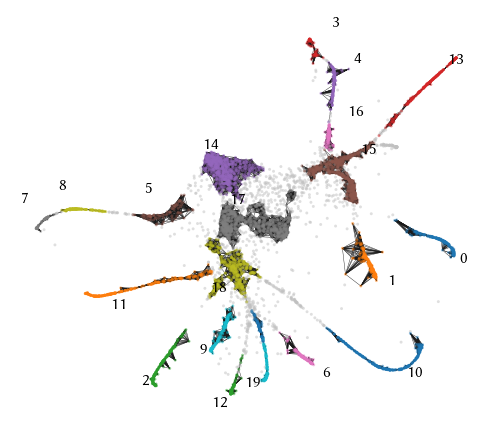

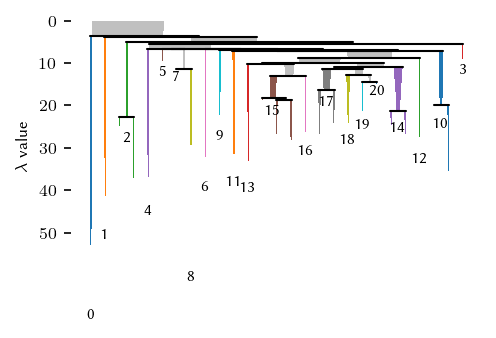

In [10]:
# Plot result
fig = sized_fig(1)
graph = c.cluster_approximation_graph_
cmap = plt.colormaps["tab10"].colors
graph.plot(
    positions=X2, 
    node_color=c.cluster_labels_ % 10, 
    node_cmap='tab10', 
    node_vmin=0,
    node_vmax=9,
    node_size=2, 
    node_alpha=0.5,
    edge_width=0.2
)
label_groups(X2, c.cluster_labels_)
frame_off()

fig = sized_fig(1/2)
c.condensed_tree_.plot(leaf_separation=0.2, label_clusters=True)
plt.subplots_adjust(0, 0, 1, 1)
# plt.savefig('./images/elegans_umap.png', dpi=600)
plt.show()

## Branches

First we look at branches in the data itself. To make this work, the clustering stage needs to filter out outlier points through a cluster selection epsilon value. Then, the branches with sensitive detection settings neatly correlate to the structure present in the embedding. The hierarchy also matches which branches merge close together.

In [11]:
# Run FLASC on 3D
c = FLASC(
    min_samples=1,
    min_branch_size=50,
    min_cluster_size=500,
    allow_single_cluster=True,
    branch_detection_method="core",
    branch_selection_method="leaf",
    branch_selection_persistence=0.015,
    cluster_selection_epsilon=1/1.5
).fit(X)
graph = c.cluster_approximation_graph_
# Geodesic labels
# labels, branch_labels = update_labels_with_branch_centrality(c, branch_centrality_vectors(c))

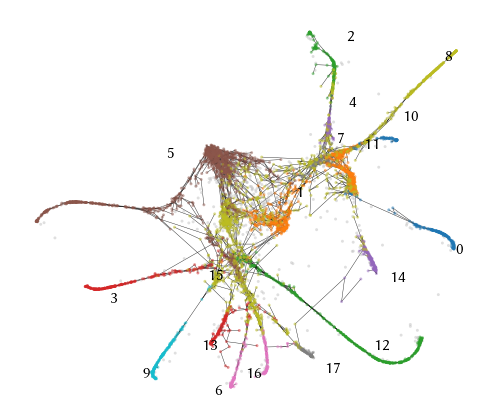

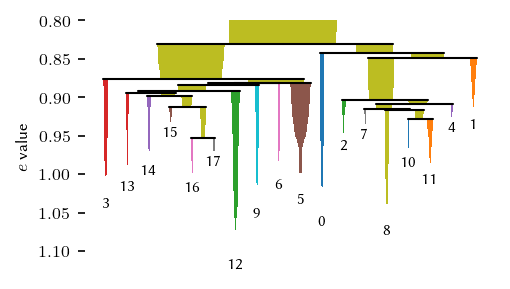

In [12]:
# Plot result
fig = sized_fig(1)
graph = c.cluster_approximation_graph_
cmap = plt.colormaps["tab10"].colors
graph.plot(
    positions=X2, 
    node_color=c.labels_ % 10, 
    node_cmap='tab10', 
    node_vmin=0,
    node_vmax=9,
    node_size=2, 
    node_alpha=0.5,
    edge_width=0.2
)
label_groups(X2, c.labels_)
frame_off()

fig = sized_fig(1/2)
c.cluster_condensed_trees_[0].plot(leaf_separation=0.2, label_clusters=True)
plt.ylim(1.13, 0.8)
plt.subplots_adjust(0, 0, 1, 1)
# plt.savefig('./images/elegans_umap.png', dpi=600)
plt.show()

### Branches in the embedding

We can also try to detect branches in an embedding. In this case, the branch hierarchy in an 3D embedding best matches the structure we percieve from the 2D embedding (3D provides space to resolve branch-overlaps, which tend to get stuck in a 2D embedding).

In [13]:
# Run FLASC on 3D embedding
c = FLASC(
    min_samples=1,
    min_branch_size=50,
    min_cluster_size=500,
    allow_single_cluster=True,
    branch_detection_method="core",
    branch_selection_method="leaf",
    branch_selection_persistence=0.05
).fit(p.embedding_)
# Geodesic labels
# labels, branch_labels = update_labels_with_branch_centrality(c, branch_centrality_vectors(c))

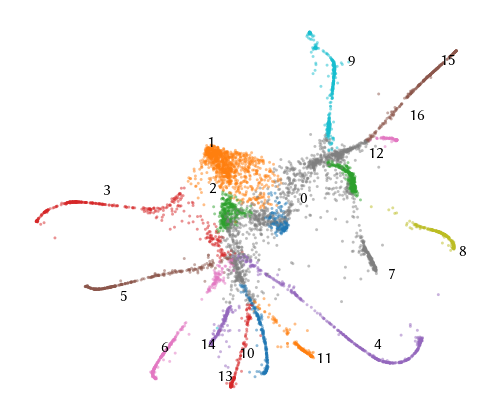

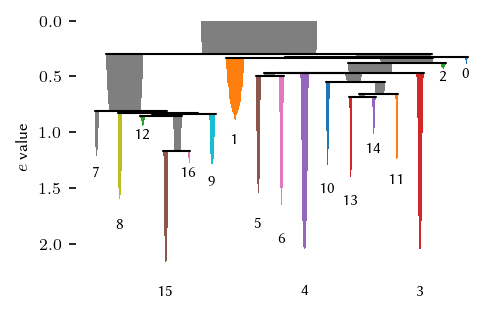

In [14]:
# Plot result
fig = sized_fig(1)
graph = c.cluster_approximation_graph_
cmap = plt.colormaps["tab10"].colors
graph.plot(
    positions=X2, 
    node_color=c.labels_ % 10, 
    node_cmap='tab10', 
    node_vmin=0,
    node_vmax=9,
    node_size=2, 
    node_alpha=0.5,
    edge_width=0
)
label_groups(X2, c.labels_)
frame_off()

fig = sized_fig(1/2)
c.cluster_condensed_trees_[0].plot(leaf_separation=0.2, label_clusters=True)
plt.subplots_adjust(0, 0, 1, 1)
# plt.savefig('./images/elegans_umap.png', dpi=600)
plt.show()